In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import glob
import cv2
import seaborn as sns
%matplotlib inline
import tensorflow as tf
from tensorflow.keras import layers
from plantcv import plantcv as pcv
from sklearn.metrics import multilabel_confusion_matrix,ConfusionMatrixDisplay
from sklearn.utils import class_weight


In [2]:
#### read csv ####
csv_path = 'dataset.csv'
arabica_dataset = pd.read_csv(csv_path, index_col = 0)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1747 entries, 1 to 1747
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   predominant_stress  1747 non-null   int64
 1   miner               1747 non-null   int64
 2   rust                1747 non-null   int64
 3   phoma               1747 non-null   int64
 4   cercospora          1747 non-null   int64
 5   severity            1747 non-null   int64
dtypes: int64(6)
memory usage: 160.1 KB
None


,predominant_stress,miner,rust,phoma,cercospora,severity
count,1747.000000,1747.000000,1747.000000,1747.000000,1747.000000,1747.000000
mean,1.941042,0.279908,0.391528,0.203205,0.184316,1.258157
std,1.302682,0.449083,0.488232,0.402499,0.387853,0.905175
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,2.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,3.000000,1.000000,1.000000,0.000000,0.000000,2.000000
max,5.000000,1.000000,1.000000,1.000000,1.000000,4.000000


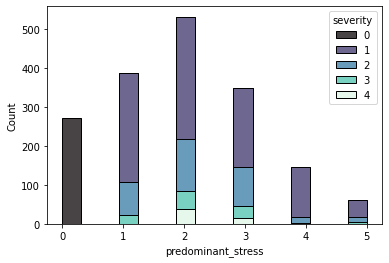

In [3]:
sns.histplot(data = arabica_dataset, x = 'predominant_stress', hue = 'severity', multiple = "stack", palette = 'mako')
print(arabica_dataset.info())
arabica_dataset.describe()

<AxesSubplot:xlabel='cercospora', ylabel='Count'>

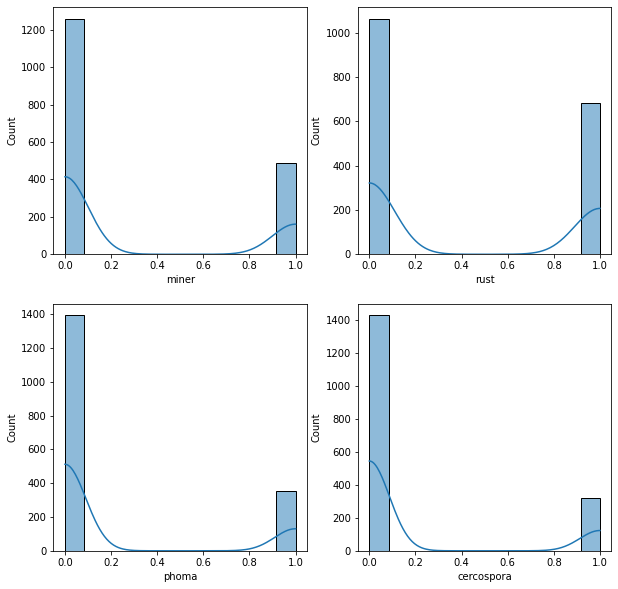

In [4]:
_,axes = plt.subplots(2,2,figsize=(10,10))
sns.histplot(data = arabica_dataset, x = 'miner', kde = True, ax = axes[0,0])
sns.histplot(data = arabica_dataset, x = 'rust', kde = True, ax = axes[0,1])
sns.histplot(data = arabica_dataset, x = 'phoma', kde = True, ax = axes[1,0])
sns.histplot(data = arabica_dataset, x = 'cercospora', kde = True, ax = axes[1,1])



*   The **severity** is skewed to less severe conditions
*   **Predominant biotic stresses** are not equally distributed
*   **Biotic stresses** are all skewed to the left with different degrees
*   Since data is skewed, it should be stratified when splitting training and testing data to ensure equal distribution and that no case is left behind in training

In [5]:
#### stratification ####
stratify_df = arabica_dataset.copy()
for col in stratify_df.columns :
    stratify_df[col] = stratify_df[col].astype(str)
stratify_df['startify_target'] = stratify_df.sum(axis = 1).astype(str)
others_mask = stratify_df['startify_target'].map(stratify_df['startify_target'].value_counts() == 1)
stratify_df['startify_target'].mask(others_mask, other = 'other', inplace = True)
train_idx,test_idx = train_test_split(arabica_dataset.index.tolist(), test_size = 0.2, stratify = stratify_df['startify_target'])
n_train = len(train_idx)
n_test = len(test_idx)

unhealthy_data_idx = arabica_dataset[arabica_dataset['severity'] != 0].index
stratify_df = arabica_dataset.loc[unhealthy_data_idx].copy()
for col in stratify_df.columns :
    stratify_df[col] = stratify_df[col].astype(str)
stratify_df['startify_target'] = stratify_df.sum(axis = 1).astype(str)
others_mask = stratify_df['startify_target'].map(stratify_df['startify_target'].value_counts() == 1)
stratify_df['startify_target'].mask(others_mask, other = 'other', inplace = True)
unhealthy_train_idx,unhealthy_test_idx = train_test_split(unhealthy_data_idx.tolist(), test_size = 0.2, stratify = stratify_df['startify_target'])
unhealthy_n_train = len(unhealthy_train_idx)
unhealthy_n_test = len(unhealthy_test_idx)

img sample path : images\1089.jpg


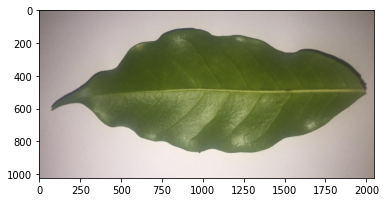

In [6]:
img_paths = glob.glob('images/*')
sample_id = 100
sample_img_path = img_paths[sample_id]
sample_img = plt.imread(sample_img_path)
ax = plt.imshow(sample_img)
print(f'img sample path : {sample_img_path}')

**NOTE : I tried using plantcv method and opencv to find the leaf and crop the bounding box of it only but I decided not to go with it because not all the images were cutted perfectly**

C:\Users\Thomas\miniconda3\envs\tf_gpu\lib\site-packages\plantcv\plantcv\closing.py:27: FutureWarning: `selem` is a deprecated argument name for `binary_closing`. It will be removed in version 1.0. Please use `footprint` instead.


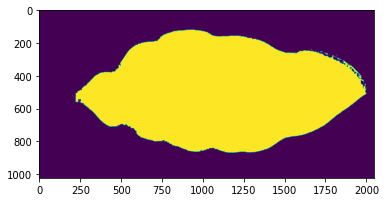

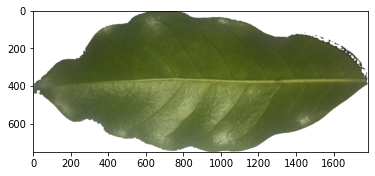

In [7]:
#### find leaf and crop it using plantCV and openCV ####
IMG_SIZE = 224

def read_resize(img_path) :
    img = plt.imread(img_path)
    resized_img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
    return resized_img

#get threshold mask
s = pcv.rgb2gray_hsv(rgb_img=sample_img, channel='s')
s_thresh = pcv.threshold.binary(gray_img=s, threshold=50, max_value=255, object_type='light')
#apply closing
closed_s_thresh = pcv.closing(gray_img = s_thresh)
plt.imshow(closed_s_thresh)
plt.show()
masked = pcv.apply_mask(img = sample_img, mask = closed_s_thresh, mask_color = 'white')
plt.imshow(masked)
#crop 
gray = cv2.cvtColor(masked, cv2.COLOR_BGR2GRAY)
th, threshed = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY_INV)

#morph close to remove noise
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
morphed = cv2.morphologyEx(threshed, cv2.MORPH_CLOSE, kernel)

#find max-area contour
cnts = cv2.findContours(morphed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2]
cnt = sorted(cnts, key=cv2.contourArea)[-1]
x,y,w,h = cv2.boundingRect(cnt)
dst = masked[y:y+h, x:x+w]

plt.imshow(dst)

In [8]:
#### build training/testing data ####
stresses_targets = ['miner','rust','phoma','cercospora']
img_paths = sorted(img_paths,key = lambda x : int(x.split('\\')[-1].split('.')[0]))
imgs_list = map(read_resize, img_paths)
imgs_np = np.stack(imgs_list, axis=0 )
del imgs_list

C:\Users\Thomas\miniconda3\envs\tf_gpu\lib\site-packages\IPython\core\interactiveshell.py:3377: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


(1397, 224, 224, 3) (350, 224, 224, 3) (1397, 4) (350, 4)
[0 0 0 0]
11


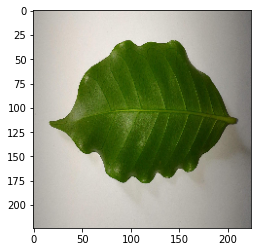

[1 1 0 0]
Index(['miner', 'rust', 'phoma', 'cercospora'], dtype='object')


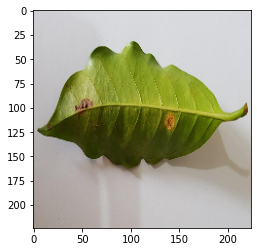

In [9]:
X_train = imgs_np[[int(x) - 1 for x in train_idx],:,:,:]
X_test = imgs_np[[int(x) - 1 for x in test_idx],:,:,:]
y_train = arabica_dataset.loc[train_idx,stresses_targets]
y_test = arabica_dataset.loc[test_idx,stresses_targets]
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)


unhealthy_X_train = imgs_np[[int(x) - 1 for x in unhealthy_train_idx],:,:,:]
unhealthy_X_test = imgs_np[[int(x) - 1 for x in unhealthy_test_idx],:,:,:]
unhealthy_y_train = arabica_dataset.loc[unhealthy_train_idx,stresses_targets]
unhealthy_y_test = arabica_dataset.loc[unhealthy_test_idx,stresses_targets]

idx = 20
print(y_train.iloc[idx].values)
print(y_train.iloc[idx].name)
plt.imshow(X_train[idx,:,:,:])
plt.show()
print(y_test.iloc[idx].values)
print(y_test.iloc[idx].index)
plt.imshow(X_test[idx,:,:,:])

Since dataset is small, to reduce overfitting data augmentation is used

Here I decided to go with flipping, rotation

In [10]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255,
        horizontal_flip=True,
        vertical_flip = True,
        rotation_range = 30
    
        )
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255
        )

Experiment #1 

Fine Tuned **ResNet50** 

Since this is a multi-label classification task :


*   N neurons with sigmoid activations will be used as output
*   binary cross entropy as a loss function
*   binary accuracy as a metric (with a default threshold of 0.5) and not categorical accuracy because each output represents an independent probabilty



In [11]:
#### building the model ####
lr = 0.001

base_model =  tf.keras.applications.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape= (IMG_SIZE,IMG_SIZE,3)
)
base_model.trainable = True

inputs = layers.Input(shape = (IMG_SIZE,IMG_SIZE,3), name = 'inpu_layer')
x = base_model(inputs, training = True)
x = layers.GlobalMaxPool2D(name = 'GMP_1')(x)
x = layers.Flatten(name = 'Flatten_1')(x)
outputs = layers.Dense(len(stresses_targets), activation = 'sigmoid', name = 'output_layer')(x)
model_1 = tf.keras.Model(inputs,outputs, name = 'model_1')
model_1.compile(
  loss = tf.keras.losses.BinaryCrossentropy() , optimizer = tf.keras.optimizers.Adam(learning_rate = lr), metrics = ["binary_accuracy"]
)
model_1.summary()


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inpu_layer (InputLayer)      [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
GMP_1 (GlobalMaxPooling2D)   (None, 2048)              0         
_________________________________________________________________
Flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
output_layer (Dense)         (None, 4)                 8196      
Total params: 23,595,908
Trainable params: 23,542,788
Non-trainable params: 53,120
_________________________________________________________________


**Callbacks used :**


*   **Learning rate scheduler** : weight decay to take advantage of quicker convergence and avoid overshooting, learning rate will drop 0.5 of it's value each 10 epochs
*   **early stopping** : to stop training if there is no 0.01 improvement in accuracy for 10 epochs and restore the best weights for the maximum validation accuracy 



In [15]:
#### callbacks ####

def lrscheduler(epoch, lr):
    decay_factor = 0.8
    decay_rate = 10
    if (epoch  % decay_rate == 0) and (epoch != 0):
        lr *= decay_factor  
    return lr
weight_decay_callback = tf.keras.callbacks.LearningRateScheduler(lrscheduler, verbose = 1)


early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta = 0.01, patience = 10, verbose = 1,
    mode='min', baseline=None, restore_best_weights = True
)

callbacks = [weight_decay_callback,early_stopping_callback]

In [13]:
epochs = 100
batch_size = 32
history = model_1.fit(
  train_datagen.flow(X_train, y_train.values, batch_size = batch_size),
  steps_per_epoch = n_train // batch_size,
  validation_data = test_datagen.flow(X_test, y_test.values, batch_size = batch_size),
  epochs=epochs,
  callbacks = callbacks
  )

Epoch 1/100

Epoch 00001: LearningRateScheduler setting learning rate to 0.0010000000474974513.
43/43 [==============================] - 29s 446ms/step - loss: 1.9927 - binary_accuracy: 0.7575 - val_loss: 0.7996 - val_binary_accuracy: 0.7893
Epoch 2/100

Epoch 00002: LearningRateScheduler setting learning rate to 0.0010000000474974513.
43/43 [==============================] - 14s 333ms/step - loss: 0.7864 - binary_accuracy: 0.8260 - val_loss: 0.5890 - val_binary_accuracy: 0.8721
Epoch 3/100

Epoch 00003: LearningRateScheduler setting learning rate to 0.0010000000474974513.
43/43 [==============================] - 14s 334ms/step - loss: 0.4434 - binary_accuracy: 0.8654 - val_loss: 0.2739 - val_binary_accuracy: 0.9121
Epoch 4/100

Epoch 00004: LearningRateScheduler setting learning rate to 0.0010000000474974513.
43/43 [==============================] - 14s 335ms/step - loss: 0.3282 - binary_accuracy: 0.8985 - val_loss: 0.3424 - val_binary_accuracy: 0.8900
Epoch 5/100

Epoch 00005: Learni

In [16]:
#model_1.save('ResNet50_Stresses')
results = model_1.evaluate(test_datagen.flow(X_test, y_test.values, batch_size = 32))
test_loss, test_accuracy = results
print(f'Test loss : {test_loss:.2f}\nTest accuracy : {test_accuracy:.3f}%\nUsing ResNet50')

11/11 [==============================] - 2s 95ms/step - loss: 0.2193 - binary_accuracy: 0.9229
Test loss : 0.22
Test accuracy : 0.923%
Using EfficientNetB0


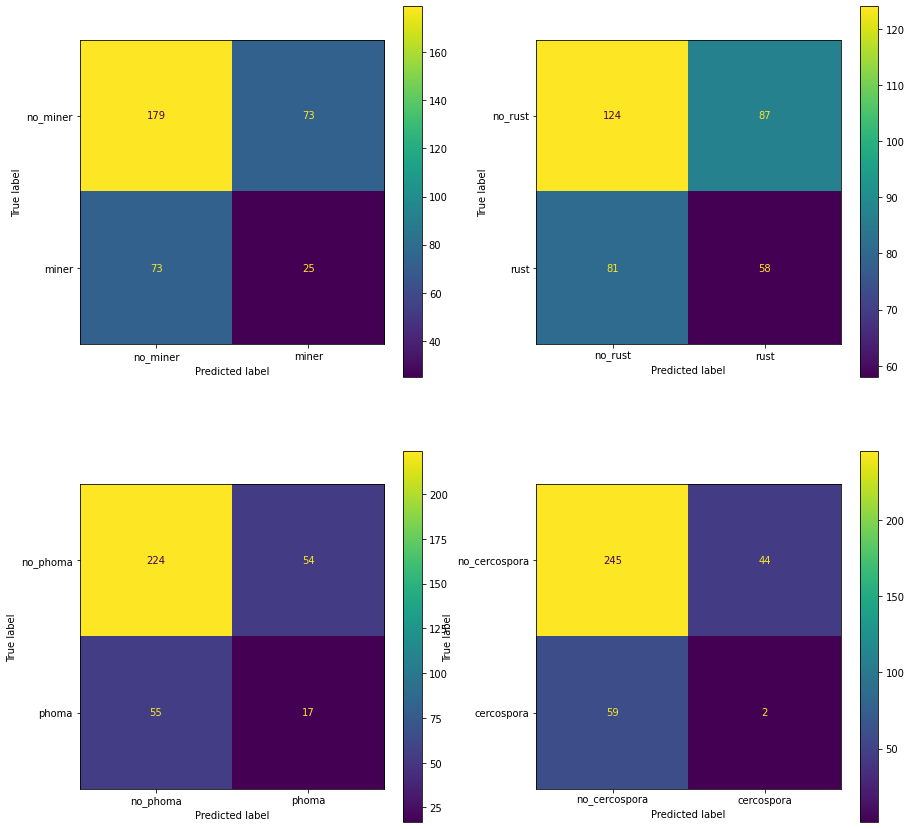

In [20]:
#### plot confusion matrix for each label ####
y_test_pred = model_1.predict(test_datagen.flow(X_test, batch_size = 32))
y_test_pred = np.around(y_test_pred).astype(int)
y_test_vals = y_test.values.astype(int)
i = 0
_,axes = plt.subplots(2,2,figsize=(15,15))
for display_labels in stresses_targets:
    y_test_vals_i = y_test_vals[:,i]
    y_test_pred_i = y_test_pred[:,i]
    ConfusionMatrixDisplay.from_predictions(y_test_vals_i, y_test_pred_i, ax = axes [i//2,i%2], display_labels = np.array([f'no_{display_labels}',f'{display_labels}']))
    i+= 1

Due to **skewness** in the data I will try to model healthy or unhealthy leaves on their own

In [11]:
y_healthy = arabica_dataset['severity'].copy()
y_healthy[y_healthy != 0] = 1
y_healthy_train = y_healthy.iloc[[int(x) - 1 for x in train_idx]]
y_healthy_test = y_healthy.iloc[[int(x) - 1 for x in test_idx]]
y_healthy.value_counts()

1    1473
0     274
Name: severity, dtype: int64

In [17]:
#### callbacks ####

def lrscheduler(epoch, lr):
    decay_factor = 0.8
    decay_rate = 5
    if (epoch  % decay_rate == 0) and (epoch != 0):
        lr *= decay_factor  
    return lr
weight_decay_callback = tf.keras.callbacks.LearningRateScheduler(lrscheduler, verbose = 1)


early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_binary_accuracy', min_delta = 0.01, patience = 20, verbose = 1,
    mode='max', baseline=None, restore_best_weights = True
)

callbacks = [weight_decay_callback,early_stopping_callback]

In [48]:
#### building the model ####
lr = 1e-4

base_model =  tf.keras.applications.ResNet50V2(
    include_top=False,
    weights='imagenet',
    input_shape= (IMG_SIZE,IMG_SIZE,3)
)
base_model.trainable = True

inputs = layers.Input(shape = (IMG_SIZE,IMG_SIZE,3), name = 'input_layer')
x = base_model(inputs, training = True)
x = layers.GlobalAvgPool2D(name = 'GMP_1')(x)
x = layers.Flatten(name = 'Flatten_1')(x)
outputs = layers.Dense(1, activation = 'sigmoid', name = 'output_layer')(x)
model_2 = tf.keras.Model(inputs,outputs, name = 'model_2')
model_2.compile(
  loss = tf.keras.losses.BinaryCrossentropy() , optimizer = tf.keras.optimizers.Adam(learning_rate = lr), metrics = ["binary_accuracy"]
)
model_2.summary()


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50v2 (Functional)      (None, 7, 7, 2048)        23564800  
_________________________________________________________________
GMP_1 (GlobalAveragePooling2 (None, 2048)              0         
_________________________________________________________________
Flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
output_layer (Dense)         (None, 1)                 2049      
Total params: 23,566,849
Trainable params: 23,521,409
Non-trainable params: 45,440
_________________________________________________________________


In [19]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(
class_weight = "balanced",
classes = np.unique(y_healthy.values),
y = y_healthy.values
)
class_weights = dict(zip(np.unique(y_healthy.values), class_weights))
class_weights

{0: 3.187956204379562, 1: 0.5930074677528853}

In [ ]:
epochs = 100
batch_size = 32
history = model_2.fit(
  train_datagen.flow(X_train, y_healthy_train.values, batch_size = batch_size),
  steps_per_epoch = n_train // batch_size,
  validation_data = test_datagen.flow(X_test, y_healthy_test.values, batch_size = batch_size),
  epochs=epochs,
  callbacks = callbacks
)

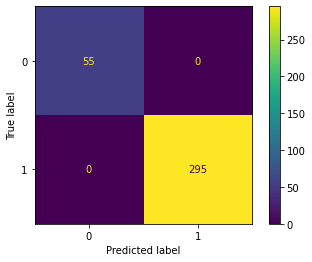

In [21]:
#### plot confusion matrix for each label ####
y_healthy_test_pred = model_2.predict(test_datagen.flow(X_test, batch_size = 32))
y_healthy_test_pred = np.around(y_healthy_test_pred).astype(int)
y_healthy_test_vals = y_healthy_test.values.astype(int)
ConfusionMatrixDisplay.from_predictions(y_healthy_test_pred, y_healthy_test_pred)

**Looks much better !**

Also this makes more sense since distinguishing healthy/unhealthy leaves is a much more important task than predicting the diseases and their levels

In [11]:
unhealthy_data_idx = arabica_dataset[arabica_dataset['severity'] != 0].index
#### stratification ####
stratify_df = arabica_dataset.loc[unhealthy_data_idx].copy()
for col in stratify_df.columns :
    stratify_df[col] = stratify_df[col].astype(str)
stratify_df['startify_target'] = stratify_df.sum(axis = 1).astype(str)
others_mask = stratify_df['startify_target'].map(stratify_df['startify_target'].value_counts() == 1)
stratify_df['startify_target'].mask(others_mask, other = 'other', inplace = True)
unhealthy_train_idx,unhealthy_test_idx = train_test_split(unhealthy_data_idx.tolist(), test_size = 0.2, stratify = stratify_df['startify_target'])
unhealthy_n_train = len(unhealthy_train_idx)
unhealthy_n_test = len(unhealthy_test_idx)

In [12]:
#### building the model ####
lr = 1e-4

base_model =  tf.keras.applications.EfficientNetB1(
    include_top=False,
    weights='imagenet',
    input_shape= (IMG_SIZE,IMG_SIZE,3)
)
base_model.trainable = True

inputs = layers.Input(shape = (IMG_SIZE,IMG_SIZE,3), name = 'inpu_layer')
x = base_model(inputs, training = True)
x = layers.Dropout(0.2)(x)
x = layers.GlobalAvgPool2D(name = 'GMP_1')(x)
x = layers.Flatten(name = 'Flatten_1')(x)
outputs = layers.Dense(len(stresses_targets), activation = 'sigmoid', name = 'output_layer')(x)
model_3 = tf.keras.Model(inputs,outputs, name = 'model_3')
model_3.compile(
  loss = tf.keras.losses.BinaryCrossentropy() , optimizer = tf.keras.optimizers.Adam(learning_rate = lr), metrics = ["binary_accuracy"]
)
model_3.summary()


Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inpu_layer (InputLayer)      [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb1 (Functional)  (None, 7, 7, 1280)        6575239   
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 1280)        0         
_________________________________________________________________
GMP_1 (GlobalAveragePooling2 (None, 1280)              0         
_________________________________________________________________
Flatten_1 (Flatten)          (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 4)                 5124      
Total params: 6,580,363
Trainable params: 6,518,308
Non-trainable params: 62,055
____________________________________________

In [13]:
#### callbacks ####

def lrscheduler(epoch, lr):
    decay_factor = 0.5
    decay_rate = 5
    if (epoch  % decay_rate == 0) and (epoch != 0):
        lr *= decay_factor  
    return lr
weight_decay_callback = tf.keras.callbacks.LearningRateScheduler(lrscheduler, verbose = 1)


early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_binary_accuracy', min_delta = 0.01, patience = 20, verbose = 1,
    mode='max', baseline=None, restore_best_weights = True
)

callbacks = [weight_decay_callback,early_stopping_callback]

In [15]:
epochs = 100
batch_size = 16
history = model_3.fit(
    train_datagen.flow(unhealthy_X_train, unhealthy_y_train.values, batch_size = batch_size),
    validation_data = test_datagen.flow(unhealthy_X_test, unhealthy_y_test.values, batch_size = batch_size),
    epochs=epochs,
    steps_per_epoch = unhealthy_n_train// batch_size,
    callbacks = callbacks
)

Epoch 1/100

Epoch 00001: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
73/73 [==============================] - 24s 293ms/step - loss: 0.4849 - binary_accuracy: 0.7816 - val_loss: 0.3493 - val_binary_accuracy: 0.8669
Epoch 2/100

Epoch 00002: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
73/73 [==============================] - 16s 216ms/step - loss: 0.3268 - binary_accuracy: 0.8610 - val_loss: 0.2816 - val_binary_accuracy: 0.8864
Epoch 3/100

Epoch 00003: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
73/73 [==============================] - 16s 217ms/step - loss: 0.2708 - binary_accuracy: 0.8894 - val_loss: 0.2570 - val_binary_accuracy: 0.9000
Epoch 4/100

Epoch 00004: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
73/73 [==============================] - 16s 217ms/step - loss: 0.2445 - binary_accuracy: 0.8995 - val_loss: 0.2560 - val_binary_accuracy: 0.9034loss: 0.2402 - binary_accur
Epoch

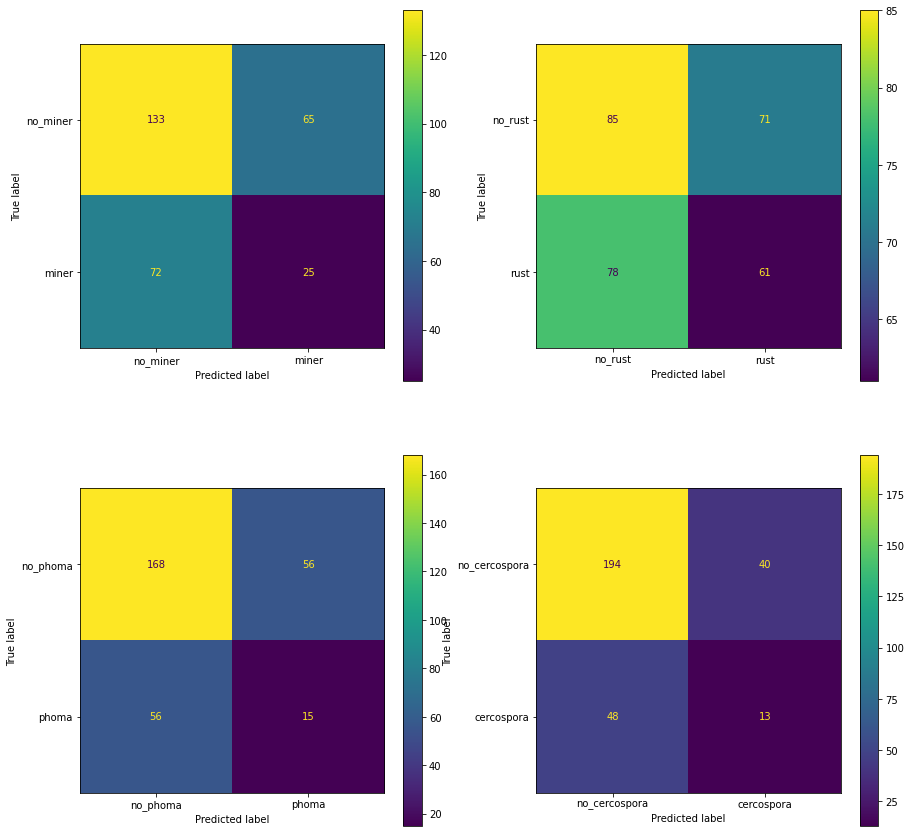

In [16]:
#### plot confusion matrix for each label ####
unhealthy_y_test_pred = model_3.predict(test_datagen.flow(unhealthy_X_test, batch_size = 32))
unhealthy_y_test_pred = np.around(unhealthy_y_test_pred).astype(int)
unhealthy_y_test_vals = unhealthy_y_test.values.astype(int)
i = 0
_,axes = plt.subplots(2,2,figsize=(15,15))
for display_labels in stresses_targets:
    unhealthy_y_test_vals_i = unhealthy_y_test_vals[:,i]
    unhealthy_y_test_pred_i = unhealthy_y_test_pred[:,i]
    ConfusionMatrixDisplay.from_predictions(unhealthy_y_test_vals_i, unhealthy_y_test_pred_i, ax = axes [i//2,i%2], display_labels = np.array([f'no_{display_labels}',f'{display_labels}']))
    i+= 1

In [ ]:
model_3.save('EfficientNetB1_stresses')

INFO:tensorflow:Assets written to: EfficientNetB1_stresses\assets


**Better confusion matrix than trying to predict healthy and unhealthy leaves together !**

In [12]:
from sklearn.utils import class_weight

unhealthy_severity_y_train = arabica_dataset.loc[unhealthy_train_idx,'severity']
unhealthy_severity_y_test = arabica_dataset.loc[unhealthy_test_idx,'severity']
n_unhealthy_severity = unhealthy_severity_y_train.nunique()
unhealthy_severity_y_train = tf.one_hot(unhealthy_severity_y_train,n_unhealthy_severity)
unhealthy_severity_y_test = tf.one_hot(unhealthy_severity_y_test,n_unhealthy_severity)
to_weight = arabica_dataset.loc[arabica_dataset['severity'] != 0,'severity']
class_weights = class_weight.compute_class_weight(
class_weight = "balanced",
classes = np.unique(to_weight.values),
y = to_weight.values
)
class_weights = dict(zip(np.unique(to_weight.values) - 1 , class_weights))
class_weights

{0: 0.3812111801242236,
 1: 1.067391304347826,
 2: 3.474056603773585,
 3: 6.575892857142857}

In [28]:
#### building the model ####
lr = 1e-4

base_model =  tf.keras.applications.ResNet50V2(
    include_top=False,
    weights='imagenet',
    input_shape= (IMG_SIZE,IMG_SIZE,3)
)
base_model.trainable = True

inputs = layers.Input(shape = (IMG_SIZE,IMG_SIZE,3), name = 'input_layer')
x = base_model(inputs, training = True)
x = layers.GlobalAvgPool2D(name = 'GMP_1')(x)
x = layers.Flatten(name = 'Flatten_1')(x)
outputs = layers.Dense(n_unhealthy_severity, activation = 'softmax', name = 'output_layer')(x)
model_5 = tf.keras.Model(inputs,outputs, name = 'model_4')
model_5.compile(
  loss = tf.keras.losses.CategoricalCrossentropy() , optimizer = tf.keras.optimizers.Adam(learning_rate = lr), metrics = ["categorical_accuracy"]
)
model_5.summary()


Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50v2 (Functional)      (None, 7, 7, 2048)        23564800  
_________________________________________________________________
GMP_1 (GlobalAveragePooling2 (None, 2048)              0         
_________________________________________________________________
Flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
output_layer (Dense)         (None, 4)                 8196      
Total params: 23,572,996
Trainable params: 23,527,556
Non-trainable params: 45,440
_________________________________________________________________


In [12]:
#### callbacks ####

def lrscheduler(epoch, lr):
    decay_factor = 0.8
    decay_rate = 5
    if (epoch  % decay_rate == 0) and (epoch != 0):
        lr *= decay_factor  
    return lr
weight_decay_callback = tf.keras.callbacks.LearningRateScheduler(lrscheduler, verbose = 1)


early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_categorical_accuracy', min_delta = 0.01, patience = 20, verbose = 1,
    mode='max', baseline=None, restore_best_weights = True
)

callbacks = [weight_decay_callback,early_stopping_callback]

In [30]:
epochs = 100
batch_size = 32
history = model_5.fit(
    train_datagen.flow(unhealthy_X_train, unhealthy_severity_y_train, batch_size = batch_size),
    validation_data = test_datagen.flow(unhealthy_X_test, unhealthy_severity_y_test, batch_size = batch_size),
    epochs=epochs,
    steps_per_epoch = unhealthy_n_train// batch_size,
    callbacks = callbacks,
    class_weight = class_weights
  )

Epoch 1/100

Epoch 00001: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
36/36 [==============================] - 16s 319ms/step - loss: 2.1323 - categorical_accuracy: 0.5201 - val_loss: 0.7497 - val_categorical_accuracy: 0.6271
Epoch 2/100

Epoch 00002: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
36/36 [==============================] - 11s 298ms/step - loss: 1.4471 - categorical_accuracy: 0.6911 - val_loss: 0.6986 - val_categorical_accuracy: 0.6271
Epoch 3/100

Epoch 00003: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
36/36 [==============================] - 11s 300ms/step - loss: 1.0228 - categorical_accuracy: 0.7587 - val_loss: 0.6710 - val_categorical_accuracy: 0.6441
Epoch 4/100

Epoch 00004: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
36/36 [==============================] - 11s 299ms/step - loss: 1.0491 - categorical_accuracy: 0.7557 - val_loss: 0.6926 - val_categorical_accuracy:

In [31]:
#model_1.save('ResNet50_Stresses')
results = model_5.evaluate(test_datagen.flow(unhealthy_X_test, unhealthy_severity_y_test, batch_size = 64))
test_loss, test_accuracy = results
print(f'Test loss : {test_loss:.2f}\nTest accuracy : {test_accuracy:.3f}%\nUsing ResNet50')

5/5 [==============================] - 1s 153ms/step - loss: 0.3507 - categorical_accuracy: 0.8339
Test loss : 0.35
Test accuracy : 0.834%
Using ResNet50
